In [1]:
import os
import concurrent
import pydicom
import numpy as np
from scipy.ndimage import zoom
import h5py
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [1]:
import os
import concurrent
import pydicom
import numpy as np
from scipy.ndimage import zoom
import pandas as pd
from tqdm import tqdm

In [2]:
class Resampler:
    def __init__(self, mode):
        self.mode = mode

    def resample(self, input_data, before_spacing, after_spacing, target_shape=None):
        if self.mode == "2D":
            resampled_image = Resampler.resample_2d(input_data, before_spacing, after_spacing)
            if target_shape:
                resampled_image = Resampler.center_crop_or_pad_2d(resampled_image, target_shape)
            
            return resampled_image

        elif self.mode == "3D":
            resampled_volume = Resampler.resample_3d(input_data, before_spacing, after_spacing)
            if target_shape:
                resampled_volume = Resampler.center_crop_or_pad_3d(resampled_volume, target_shape)
            
            return resampled_volume
    
    @staticmethod
    def resample_2d(image, before_spacing, after_spacing):
        zoom_factors = [
            before_spacing[0] / after_spacing[0], 
            before_spacing[1] / after_spacing[1], 
        ]
        
        return zoom(image, zoom=zoom_factors, order=1)
    
    @staticmethod
    def resample_3d(volume, before_spacing, after_spacing):       
        zoom_factors = [
            before_spacing[0] / after_spacing[0],
            before_spacing[1] / after_spacing[1],
            before_spacing[2] / after_spacing[2],
        ]

        return zoom(volume, zoom=zoom_factors, order=1)
    
    @staticmethod
    def center_crop_or_pad_2d(image, target_shape):
        x, y = image.shape
        tx, ty = target_shape

        # 결과를 담을 배열(Zero Padding용) 생성
        cropped_or_padded = np.zeros(target_shape, dtype=image.dtype)

        # ---------- (1) 먼저 중앙 Crop ----------
        # X축
        if x > tx:
            start_x = (x - tx) // 2
            end_x = start_x + tx
            image = image[start_x:end_x, :]
            x = tx
        # Y축
        if y > ty:
            start_y = (y - ty) // 2
            end_y = start_y + ty
            image = image[:, start_y:end_y]
            y = ty

        # ---------- (2) Zero Padding ----------
        x_pad, y_pad = image.shape
        x_start = (tx - x_pad) // 2 if x_pad < tx else 0
        y_start = (ty - y_pad) // 2 if y_pad < ty else 0

        cropped_or_padded[
            x_start : x_start + x_pad,
            y_start : y_start + y_pad
        ] = image

        return cropped_or_padded
    
    @staticmethod
    def center_crop_or_pad_3d(volume, target_shape):
        x, y, z = volume.shape
        tx, ty, tz = target_shape

        # 결과 배열 생성 (Zero Padding용)
        cropped_or_padded = np.zeros(target_shape, dtype=volume.dtype)

        # ========== (1) 중앙 Crop ==========
        # X축
        if x > tx:
            start_x = (x - tx) // 2
            end_x = start_x + tx
            volume = volume[start_x:end_x, :, :]
            x = tx
        # Y축
        if y > ty:
            start_y = (y - ty) // 2
            end_y = start_y + ty
            volume = volume[:, start_y:end_y, :]
            y = ty
        # Z축
        if z > tz:
            start_z = (z - tz) // 2
            end_z = start_z + tz
            volume = volume[:, :, start_z:end_z]
            z = tz

        # ========== (2) Zero Padding ==========
        x_pad, y_pad, z_pad = volume.shape

        x_start = (tx - x_pad) // 2 if x_pad < tx else 0
        y_start = (ty - y_pad) // 2 if y_pad < ty else 0
        z_start = (tz - z_pad) // 2 if z_pad < tz else 0

        cropped_or_padded[
            x_start : x_start + x_pad,
            y_start : y_start + y_pad,
            z_start : z_start + z_pad,
        ] = volume

        return cropped_or_padded
    
class DicomOneScanHandler:
    def __init__(self, dcms_parent_path):
        all_dcms = []
        for dcm_path in os.listdir(dcms_parent_path):
            slice_path = os.path.join(dcms_parent_path, dcm_path)
            all_dcms.append(pydicom.dcmread(slice_path))
        all_dcms.sort(key=lambda d: int(d.InstanceNumber))

        self.process_scans(all_dcms)

    def process_scans(self, dcm_list):
        volume = []
        all_spacing = None
        is_full_volume = False
        for i, dcm in enumerate(dcm_list):
            slice_ = dcm.pixel_array.astype(np.float32)  # float32 변환 (안전성 증가)
            volume.append(slice_)

            if i == 0:
                """ X, Y, Z 순의 Spacing을 담음(Z, X, Y 아님!!!)"""
                try:
                    all_spacing = list(dcm.PixelSpacing) + [dcm.SliceThickness]
                except:
                    """ADNI 에만 적용될 것으로 예상"""
                    try:
                        thickness = dcm[0x5200, 0x9230][0][0x0028, 0x9110][0][0x0028, 0x0030].value
                        pixel_spacing = dcm[0x5200, 0x9230][0][0x0028, 0x9110][0][0x0018, 0x0050].value
                        all_spacing = list(pixel_spacing) + [thickness]
                    except:
                        all_spacing = list(thickness) + [pixel_spacing] # 자리가 바뀌어 잘못 기재된 데이터
            
            if len(slice_.shape) == 3:
                volume = np.array(slice_).transpose(1, 2, 0)
                is_full_volume = True

        if not is_full_volume:
            volume = np.stack(volume, axis=0).transpose(1, 2, 0)
        # volume = np.array(volume, dtype=np.float32).transpose(1, 2, 0)  # float32 변환 & 차원 변경

        # min-max 정규화 (오버플로 방지)
        v_min, v_max = np.min(volume), np.max(volume)
        denominator = max(v_max - v_min, 1e-5)  # 0 나눗셈 방지

        normed_volume = ((volume - v_min) / denominator) * 255  # 0~255 정규화
        normed_volume = np.clip(normed_volume, 0, 255)  # 0~255 범위 유지

        self.volume = normed_volume.astype(np.uint8)  # uint8 변환 (메모리 최적화)
        self.spacing = all_spacing
        # if is_full_volume:
        #     self.visualize_volume_as_video(volume)

    def visualize_volume_as_video(self, personal_volume=None):
        import cv2
        target_volume = personal_volume if personal_volume is not None else self.volume
        try:
            for i in range(target_volume.shape[0]):
                frame = target_volume[i]
                cv2.imshow("brain", frame)
                if cv2.waitKey(10) == ord('q'):
                    break
        except Exception as e:
            print(e)
        finally:
            cv2.destroyAllWindows()

class Dicom2NumpyPreprocessor:
    def __init__(self, voxel_size, visualize=False, target_shape=None):
        self.resampler_3D = Resampler("3D")
        self.voxel_size = voxel_size
        self.visualize = visualize
        self.target_shape = target_shape
        # self.resampler_2D = Resampler("2D")
    
    @staticmethod
    def get_MRI_class_from_scanId(csv, scan_id, mode="ADNI"):
        if mode == "K-Alzheimer":
            try:
                scan_class = csv.loc[csv["MRI convert 익명코드"] == scan_id, "3T_DATA진단명 "].values[0]
                if scan_class in ["NC"]:
                    return "CN"
                elif scan_class in ["AMCI", "aMCI"]:
                    return "MCI"
                elif scan_class in ["AD", "ADD"]:
                    return "AD"
                else:
                    raise Exception("No class found.")
            except:
                raise Exception("Code error in 'get_MRI_class_from_scanId'")
        else:
            # import random
            # return random.choice(["CN", "MCI", "AD"])
        
            matched = csv[csv["Image Data ID"] == scan_id]
            if matched.empty:
                try_folder_name = "D" + scan_id[1:]
                matched = csv[csv["Image Data ID"] == try_folder_name]
                if matched.empty:
                    raise ValueError(f"Group not found for folder {scan_id}")

            group = matched["Group"].values[0]
            if group not in ["AD", "CN", "MCI"]:
                raise ValueError(f"Invalid group '{group}' for folder {scan_id}")
            
            return group

    def preprocess_all_dicom_files_recursive(self, all_dcm_files_path):
        scans = set()
        print("모든 데이터셋 경로 탐색 시작...")
        for root, dirs, files in os.walk(all_dcm_files_path):
            for file in files:
                if file.endswith(".dcm"):
                    scans.add(root)
                    break
        scans = list(scans)
        print("스캔 개수 :", len(scans))
        print("npz 변환 시작...")
        self.make_all_numpy_files(scans)

    @staticmethod
    def process_scan(scan_path, npzs_path, resampler, voxel_size, target_shape, my_csv, visualize):
        scan_id = scan_path.replace("\\", "/").split("/")[-1]
        dcm_handler = DicomOneScanHandler(dcms_parent_path=scan_path)
        volume = dcm_handler.volume

        # Resampling 처리
        new_volume_for_deep_learning = resampler.resample(volume, dcm_handler.spacing, voxel_size, target_shape)

        # 라벨 가져오기
        label = Dicom2NumpyPreprocessor.get_MRI_class_from_scanId(my_csv, scan_id, mode="ADNI")

        # 저장 경로 설정
        save_path = os.path.join(npzs_path, label, f"{scan_id}.npz")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # 폴더 없으면 생성
        np.savez_compressed(save_path, volume=new_volume_for_deep_learning)

        # 시각화 (옵션)
        if visualize:
            DicomOneScanHandler.visualize_volume_as_video(None, volume)
            DicomOneScanHandler.visualize_volume_as_video(None, new_volume_for_deep_learning)

    def make_all_numpy_files(self, scans):
        global my_csv
        npzs_path = NPZS_PATH
        resampler = self.resampler_3D
        voxel_size = self.voxel_size
        target_shape = self.target_shape
        visualize = self.visualize
        
        with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
            futures = {
                executor.submit(Dicom2NumpyPreprocessor.process_scan, scan, npzs_path, resampler, voxel_size, target_shape, my_csv, visualize): scan
                for scan in scans
            }

            for future in tqdm(
                concurrent.futures.as_completed(futures),
                total=len(futures),
                desc="Processing Folders",
            ):
                folder = futures[future]
                try:
                    future.result()
                except Exception as e:
                    print(f"[ERROR] Folder: {folder}\n   > {e}")

        print("=== Processing Complete ===")


In [3]:
MODE = "ADNI"

ALL_DATASET_PATH, CSV_PATH, NPZS_PATH = None, None, None

if MODE == "ADNI":
    ALL_DATASET_PATH = r"D:\ALL_DATASETS\medical\ADNI\ADNI_DATASET"
    CSV_PATH = r"D:\ALL_DATASETS\medical\ADNI\ADNI_FULL.csv"
    NPZS_PATH = r"C:\Working\LAB\2025\K_Alzheimer\download\npz_patients"
elif MODE == "K-Alzheimer":
    ALL_DATASET_PATH = r"/home/ubuntu/path_to_dataset"
    CSV_PATH = r"/home/ubuntu/path_to_csv"
    NPZS_PATH = r"/home/ubuntu/path_to_npzs"
else:
    raise ValueError("Invalid mode. Please choose 'ADNI' or 'K-Alzheimer'.")


In [4]:
handler = DicomOneScanHandler(r"D:\ALL_DATASETS\medical\ADNI\ADNI_DATASET\003_S_6644\Accelerated_Sagittal_MPRAGE\2018-12-04_14_13_04.0\I1083042")
resampler = Resampler(mode="ADNI")

원본 볼륨 크기 : (256, 240, 208)
원본 Spacing : ['1.0', '1.0', '1.0']
아래 사진의 크기 : (240, 208)


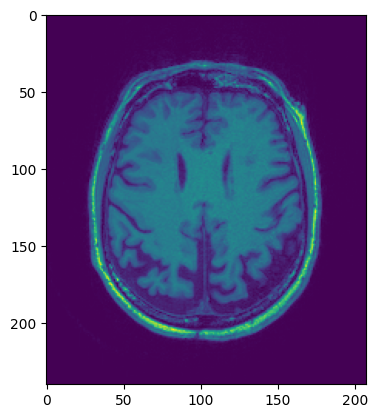

In [5]:
import matplotlib.pyplot as plt
plt.imshow(handler.volume[112])
print("원본 볼륨 크기 :", handler.volume.shape)
print("원본 Spacing :", handler.spacing)
print("아래 사진의 크기 :", handler.volume[112].shape)

Resample Spacing : (0.5, 0.5)
아래 사진의 크기 : (480, 416)


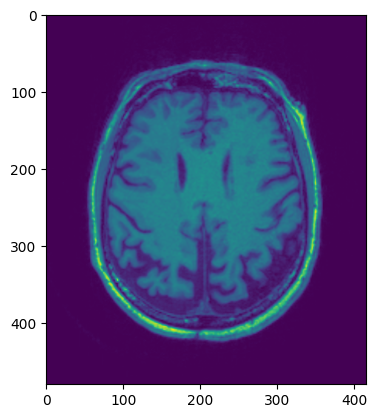

In [6]:
resample_spacing = (0.5, 0.5)
resampled_img = resampler.resample_2d(handler.volume[112], handler.spacing, resample_spacing)
print("Resample Spacing :", resample_spacing)
print("아래 사진의 크기 :", resampled_img.shape)
plt.imshow(resampled_img)

0 185
(480, 480)


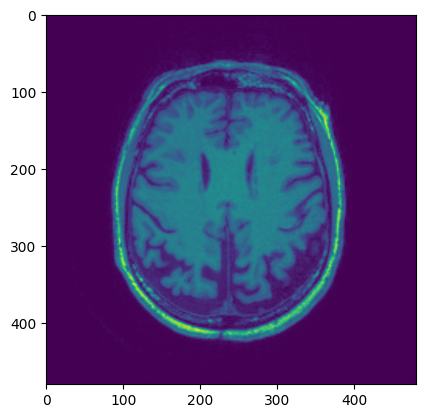

In [14]:
k_alz_img = np.zeros((480, 480), dtype=np.uint8)
k_alz_img[:, 31:447] = resampler.resample_2d(handler.volume[112], handler.spacing, resample_spacing)
print(k_alz_img.shape)
plt.imshow(k_alz_img)

In [16]:
resampled_k_alz_as_1mm = resampler.resample_2d(k_alz_img, (0.5, 0.5), (1.0, 1.0))

아래 사진의 크기 : (224, 224)


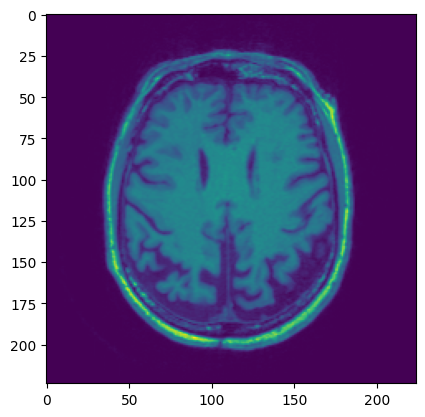

In [18]:
size = resampled_k_alz_as_1mm.shape[0]
k_alz_img_dl = resampled_k_alz_as_1mm[size // 2 - 112 : size // 2 + 112, size // 2 - 112 : size // 2 + 112]
print("아래 사진의 크기 :", k_alz_img_dl.shape)
plt.imshow(k_alz_img_dl)